In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import os, re
from os import listdir
from os.path import isfile, join

In [2]:
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten, ELU, LSTM, TimeDistributed,Input
import matplotlib.pyplot as plt
from keras.layers import Conv1D, MaxPooling1D, Flatten, Conv2D, BatchNormalization, Lambda, MaxPooling2D
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras import backend
from keras.utils import np_utils
from keras.optimizers import Adam, RMSprop
from keras import regularizers
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [3]:
npzfile = np.load('df_zero_arr.npz')
print(npzfile.files)
X = npzfile['arr_0']
y = npzfile['arr_1']
print(X.shape, y.shape)

['arr_0', 'arr_1']
(36480, 128, 130) (36480,)


In [4]:
y_onehot = np.eye(10)[y]
y_onehot.shape

(36480, 10)

In [5]:
X = X.swapaxes(1,2)
X.shape

(36480, 130, 128)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y_onehot, test_size=0.2, random_state=42)
y_train.shape

(29184, 10)

In [11]:
BATCH_SIZE = 64
num_classes = 10
FILTER_LENGTH = 5
CONV_FILTER_COUNT = 64
LSTM_COUNT = 96
EPOCH_COUNT = 500
NUM_HIDDEN = 64
L2_regularization = 0.001

model = Sequential()
model.add(Conv1D(input_shape=(None,128),filters=64,
                kernel_size=5,
                kernel_regularizer=regularizers.l2(L2_regularization)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.4))

model.add(Conv1D(filters=128,
                kernel_size=5,
                kernel_regularizer=regularizers.l2(L2_regularization)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.4))

model.add(Conv1D(filters=64,
                kernel_size=5,
                kernel_regularizer=regularizers.l2(L2_regularization)))
model.add(BatchNormalization(momentum=0.9))
model.add(Activation('relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(0.4))

model.add(LSTM(LSTM_COUNT, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(NUM_HIDDEN, kernel_regularizer=regularizers.l2(L2_regularization)))
model.add(Dropout(0.4))
model.add(Dense(num_classes))
model.add(Activation('softmax', name='output_realtime'))



# initiate Adam optimizer
opt = Adam(lr=0.001)

# Let's train the model using Adam
model.compile(
            loss='categorical_crossentropy',
            optimizer=opt,
            metrics=['accuracy']
        )

print(model.summary())


earlystop = EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='min')

reducelr_callback = ReduceLROnPlateau(
                monitor='val_loss', factor=0.5, patience=5, min_delta=0.01,
                verbose=1, mode='min'
            )

model_history = model.fit(X_train, 
                          y_train,
                          batch_size=BATCH_SIZE,
                    epochs=EPOCH_COUNT,
                    validation_data=(X_test, y_test),
                    workers=4,
                    callbacks=[earlystop, reducelr_callback])


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, None, 64)          41024     
                                                                 
 batch_normalization_12 (Bat  (None, None, 64)         256       
 chNormalization)                                                
                                                                 
 activation_12 (Activation)  (None, None, 64)          0         
                                                                 
 max_pooling1d_12 (MaxPoolin  (None, None, 64)         0         
 g1D)                                                            
                                                                 
 dropout_20 (Dropout)        (None, None, 64)          0         
                                                                 
 conv1d_13 (Conv1D)          (None, None, 128)        

455/456 [============================>.] - ETA: 0s - loss: 0.5893 - accuracy: 0.8695
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
456/456 [==============================] - 22s 48ms/step - loss: 0.5894 - accuracy: 0.8695 - val_loss: 0.5163 - val_accuracy: 0.8904 - lr: 5.0000e-04
Epoch 29/500
456/456 [==============================] - 22s 47ms/step - loss: 0.5407 - accuracy: 0.8856 - val_loss: 0.4792 - val_accuracy: 0.9010 - lr: 2.5000e-04
Epoch 30/500
456/456 [==============================] - 22s 48ms/step - loss: 0.5205 - accuracy: 0.8897 - val_loss: 0.4436 - val_accuracy: 0.9119 - lr: 2.5000e-04
Epoch 31/500
456/456 [==============================] - 22s 48ms/step - loss: 0.5119 - accuracy: 0.8912 - val_loss: 0.4580 - val_accuracy: 0.9086 - lr: 2.5000e-04
Epoch 32/500
456/456 [==============================] - 22s 47ms/step - loss: 0.5019 - accuracy: 0.8939 - val_loss: 0.4476 - val_accuracy: 0.9043 - lr: 2.5000e-04
Epoch 33/500
456/456 [==============

455/456 [============================>.] - ETA: 0s - loss: 0.3386 - accuracy: 0.9297
Epoch 73: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.
456/456 [==============================] - 22s 47ms/step - loss: 0.3386 - accuracy: 0.9297 - val_loss: 0.3405 - val_accuracy: 0.9311 - lr: 1.5625e-05
Epoch 74/500
456/456 [==============================] - 21s 47ms/step - loss: 0.3324 - accuracy: 0.9324 - val_loss: 0.3383 - val_accuracy: 0.9316 - lr: 7.8125e-06
Epoch 75/500
456/456 [==============================] - 22s 47ms/step - loss: 0.3352 - accuracy: 0.9301 - val_loss: 0.3490 - val_accuracy: 0.9279 - lr: 7.8125e-06
Epoch 76/500
456/456 [==============================] - 22s 47ms/step - loss: 0.3372 - accuracy: 0.9304 - val_loss: 0.3446 - val_accuracy: 0.9287 - lr: 7.8125e-06
Epoch 77/500
456/456 [==============================] - 22s 48ms/step - loss: 0.3344 - accuracy: 0.9320 - val_loss: 0.3401 - val_accuracy: 0.9306 - lr: 7.8125e-06
Epoch 78/500
455/456 [==============

In [12]:
model.save('./models/crnn/crnnmodel1.h5')

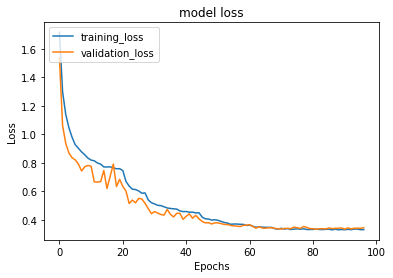

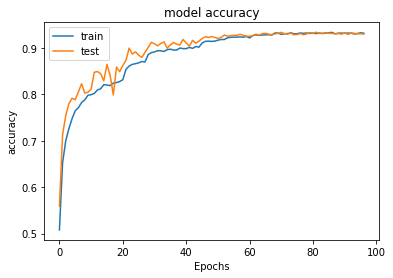

In [13]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("model loss")
plt.legend(loc='upper left')
plt.show()

training_loss = model_history.history['accuracy']
val_loss = model_history.history['val_accuracy']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("accuracy")
plt.title("model accuracy")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [14]:
dict_genres = {'blues':0, 'classical':1, 'country':2, 'disco':3, 
           'hiphop':4,'jazz':5, 'metal' :6, 'pop': 7 ,'reggae': 8 ,'rock':9}

In [15]:
from sklearn.metrics import classification_report

y_true = np.argmax(y_test, axis = 1)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7,8,9]
target_names = dict_genres.keys()

print(y_true.shape, y_pred.shape)
print(classification_report(y_true, y_pred, target_names=target_names))

228/228 [==============================] - 2s 6ms/step
(7296,) (7296,)
              precision    recall  f1-score   support

       blues       0.94      0.91      0.93       901
   classical       0.88      1.00      0.94       865
     country       0.92      0.86      0.89       500
       disco       0.99      0.98      0.98       714
      hiphop       0.95      0.92      0.93       457
        jazz       0.91      0.97      0.94       827
       metal       0.94      0.96      0.95       981
         pop       0.91      0.81      0.86       481
      reggae       0.97      0.95      0.96       660
        rock       0.91      0.87      0.89       910

    accuracy                           0.93      7296
   macro avg       0.93      0.92      0.93      7296
weighted avg       0.93      0.93      0.93      7296



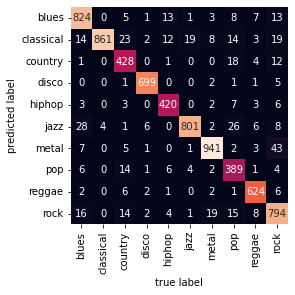

In [16]:
mat = confusion_matrix(y_true, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label');